# Travis CI Build Breaker Analysis

We just need the <tt>log</tt> files of the first level:

In [1]:
import glob
import os
ROOT_DIR = r"C:\Data\SonarSource@sonar-java"
GLOB_PATTERN = "*.log"
log_file_paths = glob.glob(os.path.join(ROOT_DIR, GLOB_PATTERN))
log_file_paths[:5]

['C:\\Data\\SonarSource@sonar-java\\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log',
 'C:\\Data\\SonarSource@sonar-java\\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925124.log',
 'C:\\Data\\SonarSource@sonar-java\\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925125.log',
 'C:\\Data\\SonarSource@sonar-java\\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925126.log',
 'C:\\Data\\SonarSource@sonar-java\\1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log']

In [2]:
import pandas as pd
# just for nicer output
pd.set_option('max_colwidth', 150)
logs = pd.DataFrame(log_file_paths, columns=['path'])
logs.head()

,path
0,C:\Data\SonarSource@sonar-java\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log
1,C:\Data\SonarSource@sonar-java\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925124.log
2,C:\Data\SonarSource@sonar-java\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925125.log
3,C:\Data\SonarSource@sonar-java\1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925126.log
4,C:\Data\SonarSource@sonar-java\1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log


We clean up these ugly, different, OS specific file separators by using the common one. (Note: We could have also used <tt>os.sep</tt>, but if you extract e. g. by a regex, it's getting unreadable.)

In [3]:
path = logs['path']
path = path.str.replace("\\", "/")
logs['path'] = path
logs.head()

,path
0,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log
1,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925124.log
2,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925125.log
3,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925126.log
4,C:/Data/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log


In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47084 entries, 0 to 47083
Data columns (total 1 columns):
path    47084 non-null object
dtypes: object(1)
memory usage: 367.9+ KB


From the path, we can extract the name of t he Jenkins job as well as the build number of the executed job.

In [5]:
logs = logs.join(logs['path'].str.extract(
        r"^.*/(?P<jobname>.*)/(?P<buildnumber>.*?)_(?P<build_id>.*?)_(?P<commit_sha>.*?)_.*\.log$", expand=True))
logs.head()

,path,jobname,buildnumber,build_id,commit_sha
0,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log,SonarSource@sonar-java,1000,75925122,19fed6256b9dfdb91e2c0149e898aacbcf9357d7
1,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925124.log,SonarSource@sonar-java,1000,75925122,19fed6256b9dfdb91e2c0149e898aacbcf9357d7
2,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925125.log,SonarSource@sonar-java,1000,75925122,19fed6256b9dfdb91e2c0149e898aacbcf9357d7
3,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925126.log,SonarSource@sonar-java,1000,75925122,19fed6256b9dfdb91e2c0149e898aacbcf9357d7
4,C:/Data/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log,SonarSource@sonar-java,1001,75929201,759f1ead70a1a8a8e889a5afc7f73787bb251fc3


In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47084 entries, 0 to 47083
Data columns (total 5 columns):
path           47084 non-null object
jobname        47084 non-null object
buildnumber    47084 non-null object
build_id       47084 non-null object
commit_sha     47084 non-null object
dtypes: object(5)
memory usage: 1.8+ MB


In [7]:
logs['buildnumber'] = logs['buildnumber'].apply(pd.to_numeric)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47084 entries, 0 to 47083
Data columns (total 5 columns):
path           47084 non-null object
jobname        47084 non-null object
buildnumber    47084 non-null int64
build_id       47084 non-null object
commit_sha     47084 non-null object
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [8]:
logs = logs.drop_duplicates(subset=['buildnumber'], keep='first')
logs.head()

,path,jobname,buildnumber,build_id,commit_sha
0,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log,SonarSource@sonar-java,1000,75925122,19fed6256b9dfdb91e2c0149e898aacbcf9357d7
4,C:/Data/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log,SonarSource@sonar-java,1001,75929201,759f1ead70a1a8a8e889a5afc7f73787bb251fc3
8,C:/Data/SonarSource@sonar-java/1002_75932199_c8c445f3fc062057c8c8b85fa29cae2e3197589d_75932200.log,SonarSource@sonar-java,1002,75932199,c8c445f3fc062057c8c8b85fa29cae2e3197589d
12,C:/Data/SonarSource@sonar-java/1003_75934919_d92aca4576d30ff97fcb7ed2302f5bd0f56d6438_75934920.log,SonarSource@sonar-java,1003,75934919,d92aca4576d30ff97fcb7ed2302f5bd0f56d6438
16,C:/Data/SonarSource@sonar-java/1004_75940558_b4a51d318eb3286cc6c8f41ba54fb221573aca31_75940561.log,SonarSource@sonar-java,1004,75940558,b4a51d318eb3286cc6c8f41ba54fb221573aca31


In [9]:
logs = logs.set_index(['buildnumber'], drop=True)
logs.head()

,path,jobname,build_id,commit_sha
buildnumber,,,,
1000,C:/Data/SonarSource@sonar-java/1000_75925122_19fed6256b9dfdb91e2c0149e898aacbcf9357d7_75925123.log,SonarSource@sonar-java,75925122,19fed6256b9dfdb91e2c0149e898aacbcf9357d7
1001,C:/Data/SonarSource@sonar-java/1001_75929201_759f1ead70a1a8a8e889a5afc7f73787bb251fc3_75929202.log,SonarSource@sonar-java,75929201,759f1ead70a1a8a8e889a5afc7f73787bb251fc3
1002,C:/Data/SonarSource@sonar-java/1002_75932199_c8c445f3fc062057c8c8b85fa29cae2e3197589d_75932200.log,SonarSource@sonar-java,75932199,c8c445f3fc062057c8c8b85fa29cae2e3197589d
1003,C:/Data/SonarSource@sonar-java/1003_75934919_d92aca4576d30ff97fcb7ed2302f5bd0f56d6438_75934920.log,SonarSource@sonar-java,75934919,d92aca4576d30ff97fcb7ed2302f5bd0f56d6438
1004,C:/Data/SonarSource@sonar-java/1004_75940558_b4a51d318eb3286cc6c8f41ba54fb221573aca31_75940561.log,SonarSource@sonar-java,75940558,b4a51d318eb3286cc6c8f41ba54fb221573aca31


Dateien aus Ordner in Liste

In [10]:
def load_all_content(file_path):
    with open(file_path, mode='r', encoding="utf-8") as f:
        return f.read()

This could take some time to execute.

In [11]:
%%time
logs['content'] = logs['path'].apply(load_all_content)
logs.head()

Wall time: 12.3 s


In [12]:
logs['content'].apply(len).sum()

1328533776

In [13]:
logs['finished'] = logs.content.str[-100:].str.extract("(.*)\n*$", expand=False)
pd.DataFrame(logs['finished'].value_counts().head(10))

,finished
Done. Your build exited with 0.,5543
Your build has been stopped.,572
Done. Your build exited with 1.,230
Done: Job Cancelled,36
The build has been terminated,22
[33;1mSee https://docs.travis-ci.com/user/workers/container-based-infrastructure/ for details.[0m,2
ostId>g73pt/Fpys9vNcdaAqNoq6FZs/gm9uzV82bQEBC4pTWHmVud/ar8Or4WEq1FLfWs6O97Rmhcd/w=</HostId></Error>,1
ostId>7S4Hmdaf5UUwBc00qyA9Hsaa8zrnkry/lCAutafFyKxy6dVLH2AmWydy1tx6BxdNyHgdz3GOsnw=</HostId></Error>,1
ostId>V/dK0Pq5THwC2Hgm4FG4ORllDieEY7dfm7ROQqRX+u40AL3g13PnF4C4XhgbGLB525qabqr7Jms=</HostId></Error>,1
ostId>7SQJebqZqnVYqCyWg2fhu+OGlQssTWXnHDkh6SkbNOfixcWU5184n/3lB5Fq8+Jqm+wndPLFfEw=</HostId></Error>,1


In [14]:
mapping = {
    "Done. Your build exited with 0." : "SUCCESS",
    "Done. Build script exited with: 0" : "SUCCESS",
    "Done. Build script exited with 0" : "SUCCUESS",
    "Your build has been stopped." : "STOPPED",
    "The build has been terminated." : "TERMINATED",
    "The build has been terminated" : "TERMINATED",
    "Done. Your build exited with 1." : "ERROR",
    "Done. Build script exited with: 1" : "ERROR",
    "Your test run exceeded " : "ABORTED"
}
logs['finished_state'] = logs['finished'].map(mapping)
logs.ix[logs['finished_state'].isnull(), "finished_state"] = "UNKNOWN"
logs['finished_state'].value_counts()

SUCCESS       5543
STOPPED        572
UNKNOWN        236
ERROR          230
TERMINATED      23
Name: finished_state, dtype: int64

In [15]:
logs['start_time'] = logs['content'].str.extract(
    r"travis_time:end:.*:start=([0-9]*),", expand=False)
logs['start_time'].head()

buildnumber
1000    1439813594146357590
1001    1439815630121194902
1002    1439816788716087665
1003    1439818175259340688
1004    1439820108000646961
Name: start_time, dtype: object

In [16]:
logs['start_time'] = pd.to_datetime(
    pd.to_numeric(
        logs['start_time'])/1000, unit='us')
logs['start_time'].head()

buildnumber
1000   2015-08-17 12:13:14.146357
1001   2015-08-17 12:47:10.121195
1002   2015-08-17 13:06:28.716087
1003   2015-08-17 13:29:35.259340
1004   2015-08-17 14:01:48.000646
Name: start_time, dtype: datetime64[ns]

In [17]:
logs['end_time'] = logs['content'].str[-500:].str.extract(
    r"travis_time:end:.*:start=[0-9]*,finish=([0-9]*)",expand=True)
logs['end_time'] = pd.to_datetime(pd.to_numeric(logs['end_time'])/1000, unit='us')
logs['end_time'].head()

buildnumber
1000   2015-08-17 12:15:22.697075
1001   2015-08-17 12:49:50.116804
1002   2015-08-17 13:09:11.630699
1003   2015-08-17 13:32:11.864482
1004   2015-08-17 14:04:28.823432
Name: end_time, dtype: datetime64[ns]

In [18]:
logs['duration'] = logs['end_time'] - logs['start_time']

In [19]:
successful_builds = logs[logs['finished_state'] == "SUCCESS"].dropna()
successful_builds['duration'].mean()

Timedelta('0 days 00:04:58.772930')

In [20]:
len(logs)

6604

In [21]:
t = successful_builds['duration']
t.memory_usage()

88688

In [22]:
successful_builds['duration_in_min'] = successful_builds['duration'].astype('timedelta64[m]')
successful_builds['duration_in_min'].head()

buildnumber
1000    2.0
1001    2.0
1002    2.0
1003    2.0
1004    2.0
Name: duration_in_min, dtype: float64

In [23]:
successful_builds_over_time = successful_builds.reset_index().set_index(pd.DatetimeIndex(successful_builds['start_time'])).resample('1W').mean()
successful_builds_over_time.head()

,buildnumber,duration_in_min
2015-05-17,12.000000,1.347826
2015-05-24,68.500000,1.511111
2015-05-31,141.132075,1.641509
2015-06-07,221.561224,1.663265
2015-06-14,317.875000,2.087500


# Visualisierung

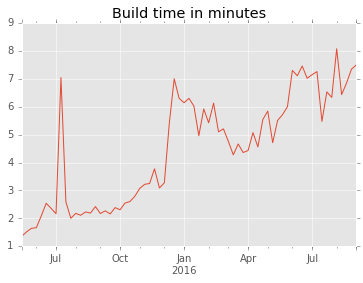

In [24]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
successful_builds_over_time['duration_in_min'].plot(
    title="Build time in minutes")